In [1]:
import pandas as pd
import numpy as np

import seaborn as sns 
import matplotlib.pyplot as plt

from statsmodels.graphics.gofplots import qqplot
from scipy.stats import shapiro, kstest

from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from joblib import dump

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.linear_model import ElasticNet
import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import r2_score, mean_absolute_error 


# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=UserWarning)

# 1 Осмотр данных

Описание признаков данных:
- date - дата публикации
- rooms - количество комнат
- level - этаж
- num_levels - всего этажа
- square_full - общая площадь
- square_live - жилая площадь
- square_other - остальная площадь
- price - цена в т.р.

In [2]:
df = pd.read_csv('sites_html.csv', sep=';')
df.head()

,date,rooms,level,num_levels,square_full,square_live,square_other,price
0,16.11,Трехкомнатная,3,4,81.0,54.0,11.0,3385
1,15.11,Многокомнатная студия,1,3,90.0,80.0,NaN,2799
2,15.11,Двухкомнатная,1,3,47.0,20.0,NaN,2057
3,15.11,Однокомнатная студия,1,3,36.0,20.0,10.0,1610
4,15.11,Однокомнатная студия,2,10,26.0,12.0,6.0,1083


In [3]:
df.describe()

,date,level,num_levels,square_full,square_live,square_other,price
count,1083.000000,1083.000000,1083.000000,1083.000000,1083.000000,1042.000000,1083.000000
mean,13.677258,8.602031,17.433056,140.296242,31.142475,11.118426,5459.414589
std,9.205170,7.040251,8.863720,1970.608032,16.581015,6.763649,3347.843554
min,1.100000,1.000000,1.000000,21.020000,0.000000,0.000000,777.000000
25%,7.100000,2.000000,10.000000,38.050000,17.000000,5.090000,3099.000000
50%,9.110000,6.000000,22.000000,54.170000,28.000000,10.000000,4723.000000
75%,22.090000,13.000000,25.000000,74.570000,41.000000,15.000000,7099.000000
max,31.100000,32.000000,36.000000,54780.000000,120.000000,92.500000,20146.000000


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1083 entries, 0 to 1082
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          1083 non-null   float64
 1   rooms         1083 non-null   object 
 2   level         1083 non-null   int64  
 3   num_levels    1083 non-null   int64  
 4   square_full   1083 non-null   float64
 5   square_live   1083 non-null   float64
 6   square_other  1042 non-null   float64
 7   price         1083 non-null   int64  
dtypes: float64(4), int64(3), object(1)
memory usage: 67.8+ KB


## Вывод
- Признак `date` нужно преобразовать в соответствующий тип данных и добавить признак: количество дней (месяцев/недель) с момента публикации
- Признак `rooms` - используем к нему One-hot encoding
- Признак `square_full` вероятно имеет выбросы (значение 54780)
- Признак `square_other` имеет пропуски


# 2 Обработка данных

## 2.1 Дубликаты

In [5]:
df[df.duplicated()]

,date,rooms,level,num_levels,square_full,square_live,square_other,price
87,13.10,Однокомнатная,4,5,66.00,33.0,18.00,8019
135,13.10,,1,26,24.80,11.0,5.00,2604
223,9.10,Двухкомнатная,1,6,73.81,29.0,23.82,5314
258,9.10,Двухкомнатная,6,6,52.87,29.0,10.72,4758
265,9.10,Однокомнатная,1,26,39.90,15.0,15.20,3790
308,7.10,Трехкомнатная,5,27,62.60,41.0,5.03,5634
365,7.10,Трехкомнатная,20,25,52.70,35.0,5.00,4532
376,7.10,Четырехкомнатная,3,25,87.68,60.0,5.00,11836
388,7.10,Трехкомнатная,5,27,62.60,41.0,10.00,5634
389,7.10,Двухкомнатная,1,27,45.76,20.0,12.36,4991


Имеютя дубликаты, избавимся от них

In [6]:
df = df[~df.duplicated()]
print('Размер датасета:', df.shape[0])

Размер датасета: 1061


## 2.2 Пропуски

In [7]:
df.isnull().sum()

date             0
rooms            0
level            0
num_levels       0
square_full      0
square_live      0
square_other    40
price            0
dtype: int64

В признаке `square_other` есть пропуски, попробуем их заполнить нулями

In [8]:
df['square_other'].fillna(0, inplace=True)
df.isnull().sum()

date            0
rooms           0
level           0
num_levels      0
square_full     0
square_live     0
square_other    0
price           0
dtype: int64

<hr>

Проверим данные на пустые строки

In [9]:
for col in df.columns:
    print(col, 'количество пропусков', df[(df[col] == ' ') | (df[col] == '')].shape[0])

date количество пропусков 0
rooms количество пропусков 93
level количество пропусков 0
num_levels количество пропусков 0
square_full количество пропусков 0
square_live количество пропусков 0
square_other количество пропусков 0
price количество пропусков 0


Есть пропуски в признаке `rooms`. Пропуски можно удалить (записи или признак) или заполнить. Заполнить можно, вероятно, значением взятых у похожих записей (*Попробовать Байес если будет время*). Пока удалим записи.

In [10]:
print(df.shape)
df.info()

(1061, 8)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1061 entries, 0 to 1082
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          1061 non-null   float64
 1   rooms         1061 non-null   object 
 2   level         1061 non-null   int64  
 3   num_levels    1061 non-null   int64  
 4   square_full   1061 non-null   float64
 5   square_live   1061 non-null   float64
 6   square_other  1061 non-null   float64
 7   price         1061 non-null   int64  
dtypes: float64(4), int64(3), object(1)
memory usage: 74.6+ KB


In [11]:
df = df[(df['rooms'] != ' ') & (df[col] != '')]
print('Размер датасета', df.shape[0])

Размер датасета 968


## 2.3 Преобразование даты

In [12]:
# Добавим год для того чтобы можно было преобразовать без ошибок
df['date'] = df['date'].astype('str') + '.2021'
df['date'] = pd.to_datetime(df['date'], format='%d.%m.%Y')
df['date'].head()

0   2021-11-16
1   2021-11-15
2   2021-11-15
3   2021-11-15
4   2021-11-15
Name: date, dtype: datetime64[ns]

In [13]:
def getDates(val):
    # Дней с момента публикации
    days_public = pd.to_datetime('2021-11-17')-val
    # Месяц публикации
    month_public = val.month
    
    return days_public.days, month_public

df['days_public'], df['month_public'] = zip(*df['date'].apply(getDates))
df['month_public'] = df['month_public'].astype('category')
df.head()

,date,rooms,level,num_levels,square_full,square_live,square_other,price,days_public,month_public
0,2021-11-16,Трехкомнатная,3,4,81.0,54.0,11.0,3385,1,11
1,2021-11-15,Многокомнатная студия,1,3,90.0,80.0,0.0,2799,2,11
2,2021-11-15,Двухкомнатная,1,3,47.0,20.0,0.0,2057,2,11
3,2021-11-15,Однокомнатная студия,1,3,36.0,20.0,10.0,1610,2,11
4,2021-11-15,Однокомнатная студия,2,10,26.0,12.0,6.0,1083,2,11


## 2.4 Преобразование "Количество комнат"
Взгляем на имеющиеся значения

In [14]:
df['rooms'].value_counts()

Трехкомнатная                          306
Однокомнатная                          292
Двухкомнатная                          284
Четырехкомнатная                        64
Многокомнатная                           4
Однокомнатная студия                     4
Трехкомнатная нестандартная              3
Двухкомнатная индивидуальный проект      2
Однокомнатная индивидуальный проект      2
Однокомнатная нестандартная              1
Двухкомнатная нестандартная              1
Двухкомнатная евродвушка                 1
Двухкомнатная раздельная                 1
Многокомнатная студия                    1
Трехкомнатная индивидуальный проект      1
Двухкомнатная стандартная                1
Name: rooms, dtype: int64

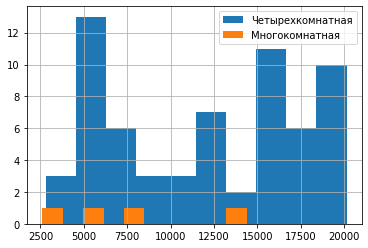

In [15]:
df[df['rooms']=='Четырехкомнатная ']['price'].hist()
df[df['rooms']=='Многокомнатная ']['price'].hist()
plt.legend(['Четырехкомнатная', 'Многокомнатная'])

Имеет несколько подпризнаков: `Студия, Индивидуальный проект, Нестандарт, Евро, Раздельная` - 
Но этих подпризнаков немного. <br>
Переопределим значения на: 1, 2, 3, 4+ (четырех- и многокомнатные объединим)

In [16]:
def setRoomsValue(val):
    if 'Одно' in val:
        return '1'
    elif 'Двух' in val:
        return '2'
    elif 'Трех' in val:
        return '3'
    else:
        return '4+'

df['rooms_vals'] = df['rooms'].apply(setRoomsValue)
df['rooms_vals'] = df['rooms_vals'].astype('category')
df.head()

,date,rooms,level,num_levels,square_full,square_live,square_other,price,days_public,month_public,rooms_vals
0,2021-11-16,Трехкомнатная,3,4,81.0,54.0,11.0,3385,1,11,3
1,2021-11-15,Многокомнатная студия,1,3,90.0,80.0,0.0,2799,2,11,4+
2,2021-11-15,Двухкомнатная,1,3,47.0,20.0,0.0,2057,2,11,2
3,2021-11-15,Однокомнатная студия,1,3,36.0,20.0,10.0,1610,2,11,1
4,2021-11-15,Однокомнатная студия,2,10,26.0,12.0,6.0,1083,2,11,1


# 2.5 Выбросы в площади

<AxesSubplot:>

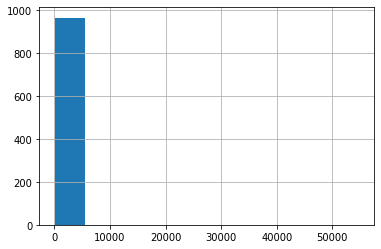

In [17]:
df['square_full'].hist()

In [18]:
df[df['square_full'] > 10000]

,date,rooms,level,num_levels,square_full,square_live,square_other,price,days_public,month_public,rooms_vals
1013,2021-09-22,Однокомнатная,2,6,34900.0,9.0,16.33,2789,56,9,1
1019,2021-09-22,Двухкомнатная,5,22,54780.0,30.0,10.50,4053,56,9,2


Вероятно некорректная размерность, поделим площадь на 1000

In [19]:
df.loc[df['square_full'] > 10000, 'square_full'] = df.loc[df['square_full'] > 10000]['square_full']/1000
df[df.index.isin([1019, 1013])]

,date,rooms,level,num_levels,square_full,square_live,square_other,price,days_public,month_public,rooms_vals
1013,2021-09-22,Однокомнатная,2,6,34.90,9.0,16.33,2789,56,9,1
1019,2021-09-22,Двухкомнатная,5,22,54.78,30.0,10.50,4053,56,9,2


<AxesSubplot:>

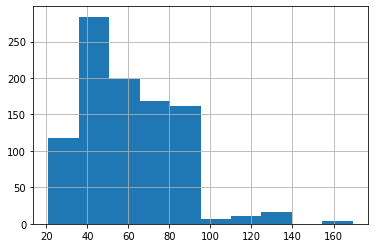

In [20]:
df['square_full'].hist()

## Вывод
- Убраны дубликаты
- Заполнены пропуски в `square_other`
- Удалены пропуски в `rooms`
- Преобразована `date` дата и добавлены новые признаки
- Удалены выбросы

# 3 Анализ

In [21]:
# Проверка выборки на нормальность
def checkNormalDist(sample, sample_name):
    qqplot(sample, line='s')
    plt.title(sample_name)
    plt.show()
    stat, p = shapiro(sample)
    print('Тест Шапиро-Уилка (Нулевая гипотеза - распределение нормальное)')
    print('Статистика=%.3f, p=%.3f' % (stat, p))
    alpha = 0.05
    if p > alpha:
        print('Выборка похожа на нормальную (не отколняем нулевю гипотезу)')
    else:
        print('Выборка не похожа на нормальную (отколняем нулевю гипотезу)')
    print()
    """
    print('Тест Колмогорова-Смирнова (Нулевая гипотеза - распределение нормальное)')
    stat, p = kstest(sample, 'norm')
    print('Статистика=%.3f, p=%.3f' % (stat, p))
    print(stat, p)    
    if p > alpha:
        print('Выборка похожа на нормальную (не отколняем нулевю гипотезу)')
    else:
        print('Выборка не похожа на нормальную (отколняем нулевю гипотезу)')
    """

## 3.1 Целевой признак

<AxesSubplot:>

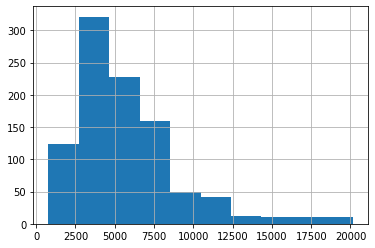

In [22]:
df['price'].hist()

Посмотрим на сколько распределение признака близко к нормальному. <br>
График QQ-plot

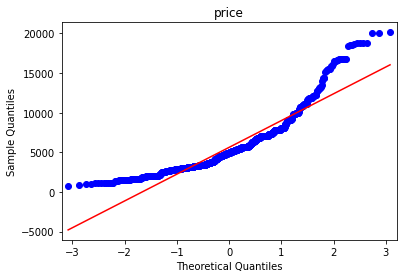

Тест Шапиро-Уилка (Нулевая гипотеза - распределение нормальное)
Статистика=0.867, p=0.000
Выборка не похожа на нормальную (отколняем нулевю гипотезу)



In [23]:
checkNormalDist(df['price'], 'price')

<hr>

Посмотрим на распределение цены за квадратный метр

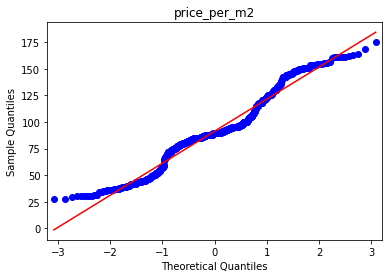

Тест Шапиро-Уилка (Нулевая гипотеза - распределение нормальное)
Статистика=0.959, p=0.000
Выборка не похожа на нормальную (отколняем нулевю гипотезу)



In [24]:
price_per_m2 = (df['price']/df['square_full'])
df['price_per_m2'] = price_per_m2
checkNormalDist(price_per_m2, 'price_per_m2')

Это распределение тоже распределено не нормально

<hr>

Попробуем трансформировать данные логарифмированием

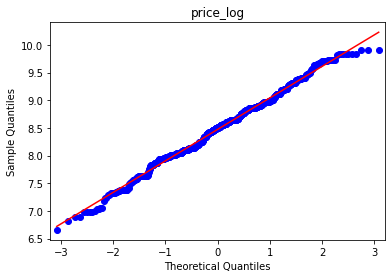

Тест Шапиро-Уилка (Нулевая гипотеза - распределение нормальное)
Статистика=0.994, p=0.001
Выборка не похожа на нормальную (отколняем нулевю гипотезу)



In [25]:
checkNormalDist(np.log(df['price']), 'price_log')

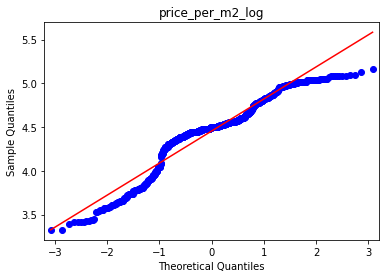

Тест Шапиро-Уилка (Нулевая гипотеза - распределение нормальное)
Статистика=0.929, p=0.000
Выборка не похожа на нормальную (отколняем нулевю гипотезу)



In [26]:
checkNormalDist(np.log(price_per_m2), 'price_per_m2_log')

## 3.2 Признаки для обучения

### 3.2.1 Корреляция

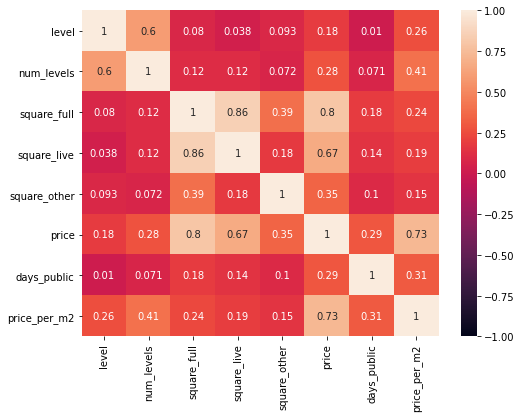

In [27]:
plt.figure(figsize=(8, 6))
ax = sns.heatmap(df.corr(), annot=True, vmin=-1.0, vmax=1.0)

Попарное сравнение

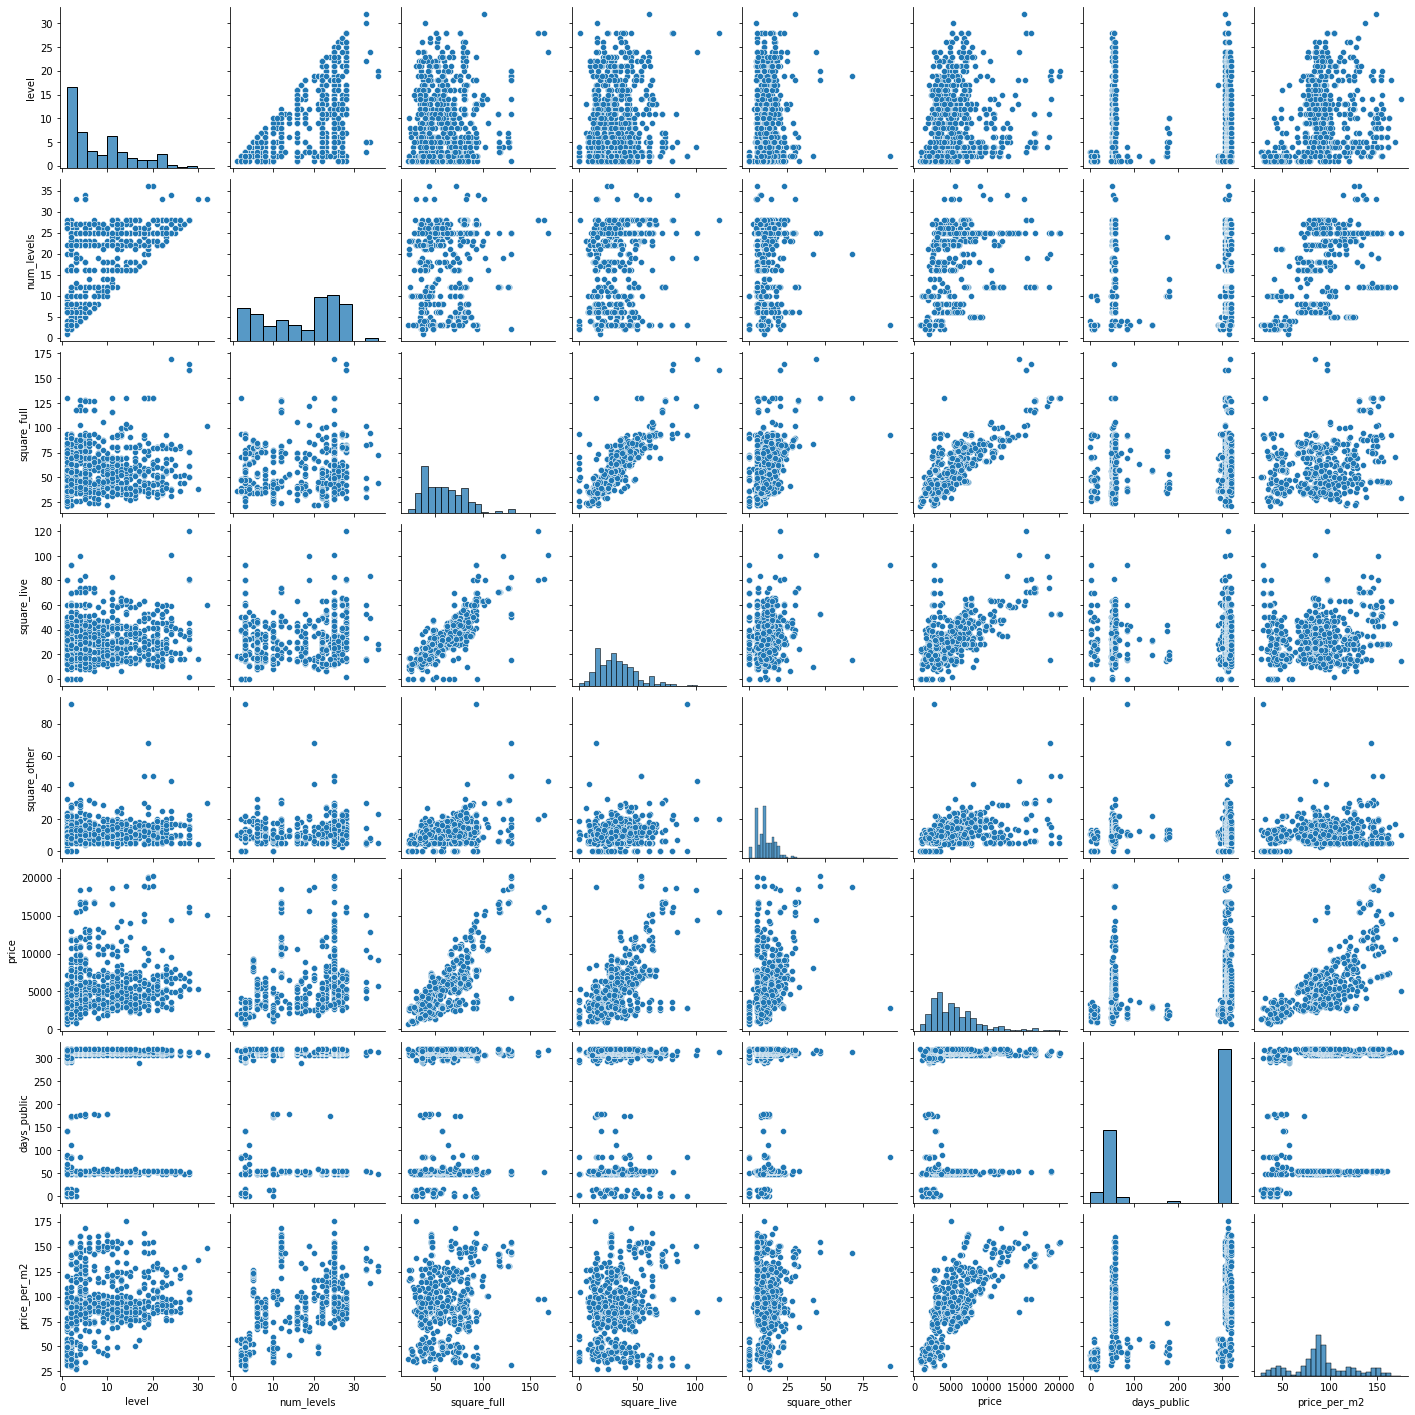

In [28]:
sns.pairplot(df)

### 3.2.2 Совместное распределение признаков с целевым

In [29]:
# Выделим типы признаков
CATEGORICAL = ['rooms_vals' , 'month_public']
NUMERICAL = ['level', 'num_levels', 'square_full', 'days_public', 'square_live', 'square_other']
OTHER_COLUMNS = ['date', 'rooms']

Числовые данные:

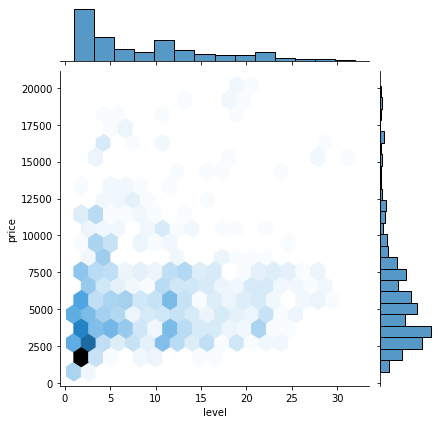

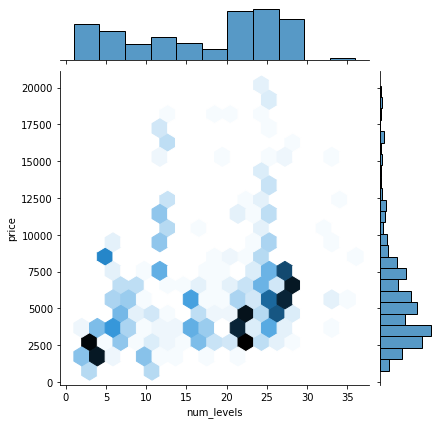

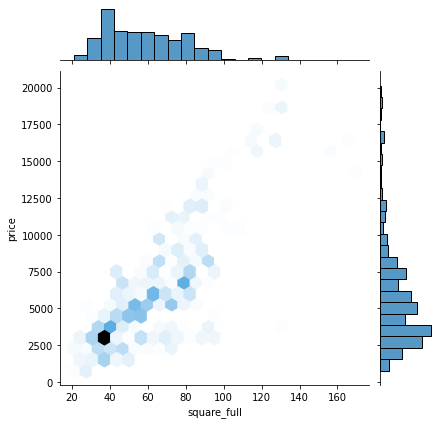

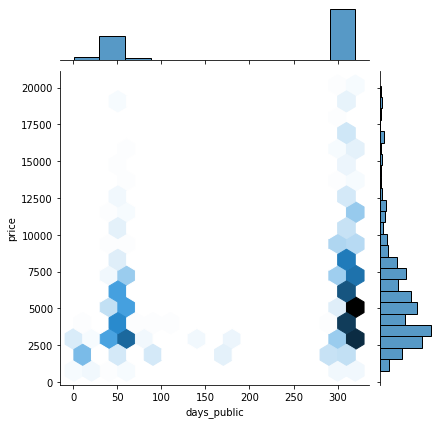

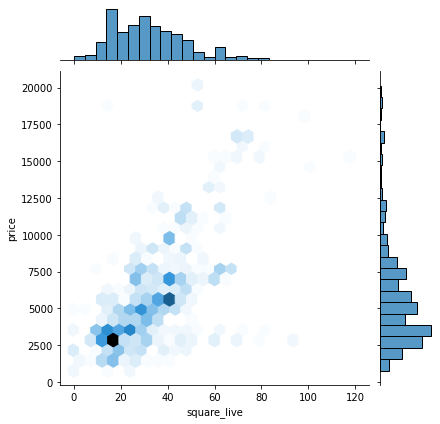

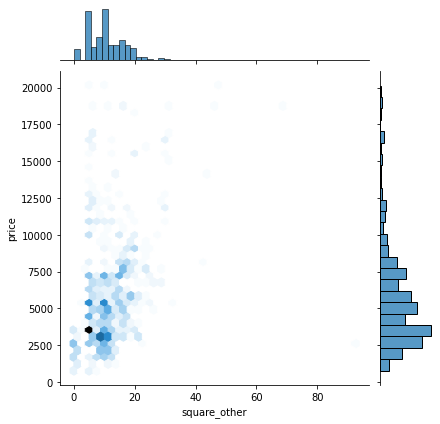

In [30]:
for col in NUMERICAL:
    sns.jointplot(data=df, x=col, y="price", kind="hex")

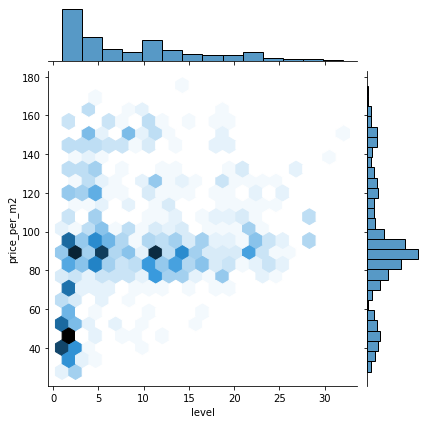

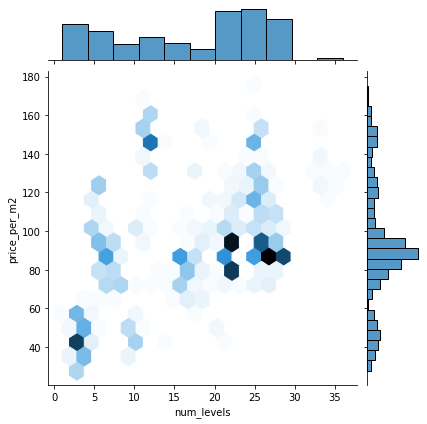

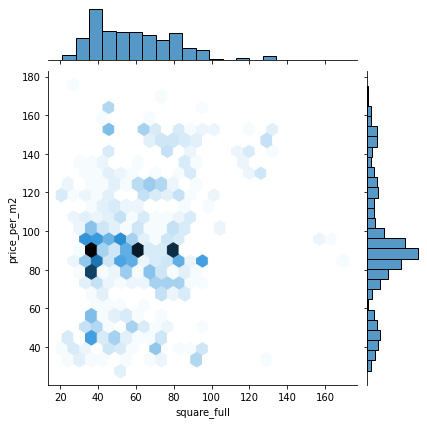

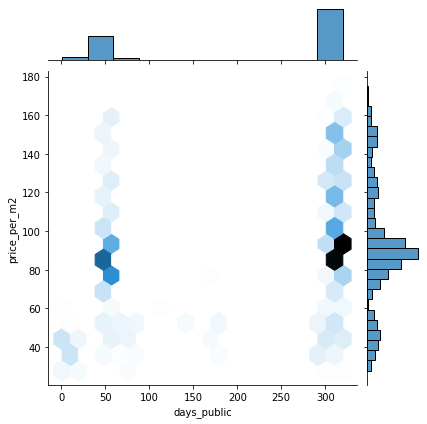

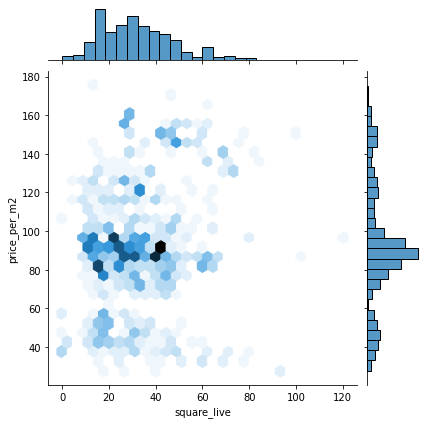

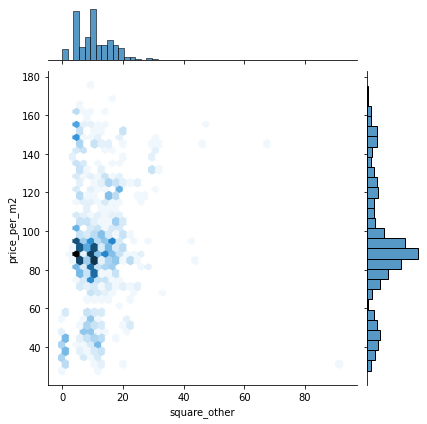

In [31]:
for col in NUMERICAL:
    sns.jointplot(data=df, x=col, y="price_per_m2", kind="hex")

Проверич числовые признаки на нормальное распределение: 

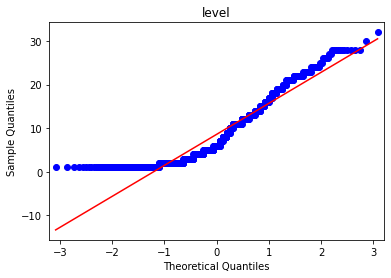

Тест Шапиро-Уилка (Нулевая гипотеза - распределение нормальное)
Статистика=0.890, p=0.000
Выборка не похожа на нормальную (отколняем нулевю гипотезу)



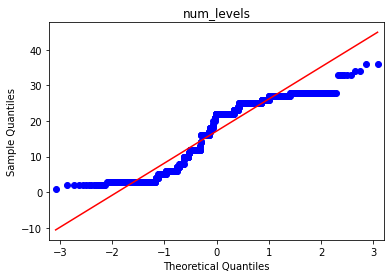

Тест Шапиро-Уилка (Нулевая гипотеза - распределение нормальное)
Статистика=0.890, p=0.000
Выборка не похожа на нормальную (отколняем нулевю гипотезу)



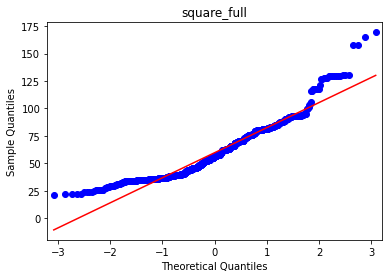

Тест Шапиро-Уилка (Нулевая гипотеза - распределение нормальное)
Статистика=0.928, p=0.000
Выборка не похожа на нормальную (отколняем нулевю гипотезу)



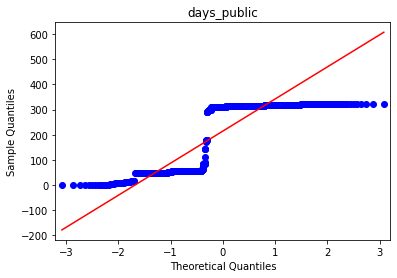

Тест Шапиро-Уилка (Нулевая гипотеза - распределение нормальное)
Статистика=0.677, p=0.000
Выборка не похожа на нормальную (отколняем нулевю гипотезу)



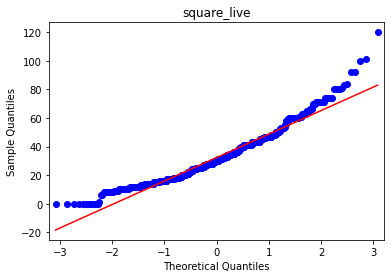

Тест Шапиро-Уилка (Нулевая гипотеза - распределение нормальное)
Статистика=0.955, p=0.000
Выборка не похожа на нормальную (отколняем нулевю гипотезу)



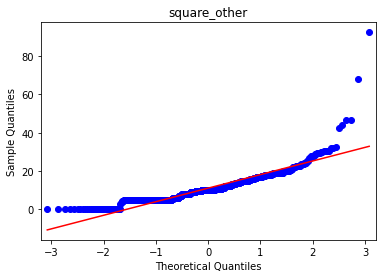

Тест Шапиро-Уилка (Нулевая гипотеза - распределение нормальное)
Статистика=0.828, p=0.000
Выборка не похожа на нормальную (отколняем нулевю гипотезу)



In [32]:
for col in NUMERICAL:
    checkNormalDist(df[col], col)

<hr>

Категориальные данные

Цена

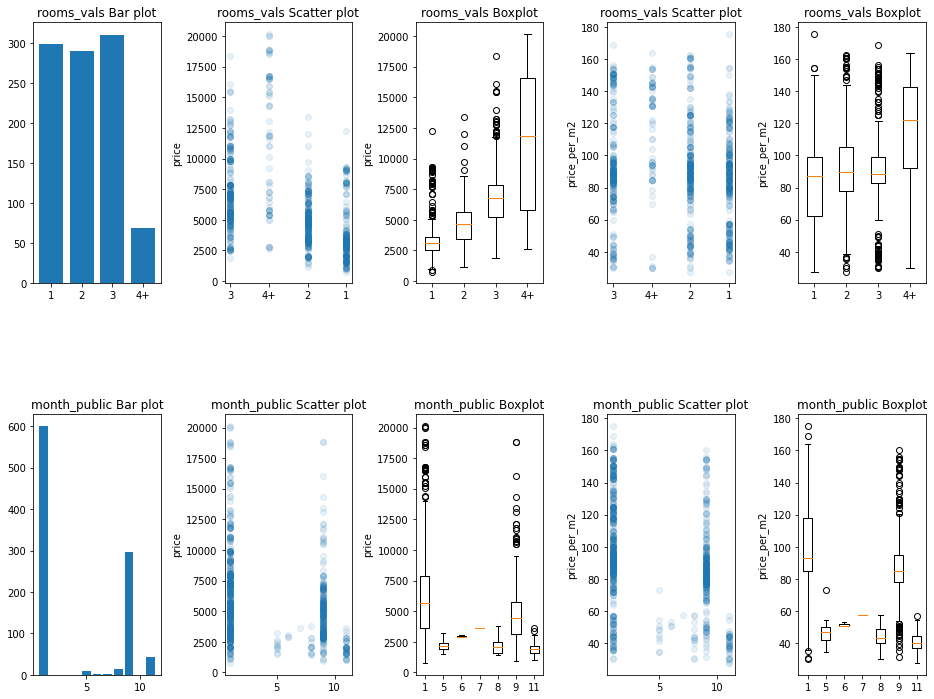

In [33]:
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning) 
axs = [0 for i in range(len(CATEGORICAL))]
fig, axs = plt.subplots(len(axs), 5)

fig.set_figwidth(16)
fig.set_figheight(12)

plt.subplots_adjust(hspace=.5, wspace=.5)

for i, cat_name in enumerate(CATEGORICAL):
    df_cat = df[cat_name].value_counts().sort_index()

    axs[i][0].set(title=cat_name+' Bar plot')
    _ = axs[i][0].bar(df_cat.index, df_cat)

    axs[i][1].set(title=cat_name+' Scatter plot')
    axs[i][1].set_ylabel('price')
    _ = axs[i][1].scatter(df[cat_name], df['price'], alpha=.1)

    axs[i][2].set(title=cat_name+' Boxplot')
    axs[i][2].set_ylabel('price')
    boxplots = [df[df[cat_name] == cat_val]['price'].values for cat_val in df_cat.index]
    _ = axs[i][2].boxplot(boxplots, labels=df_cat.index)
    
    axs[i][3].set(title=cat_name+' Scatter plot')
    axs[i][3].set_ylabel('price_per_m2')
    _ = axs[i][3].scatter(df[cat_name], df['price_per_m2'], alpha=.1)

    axs[i][4].set(title=cat_name+' Boxplot')
    axs[i][4].set_ylabel('price_per_m2')
    boxplots = [df[df[cat_name] == cat_val]['price_per_m2'].values for cat_val in df_cat.index]
    _ = axs[i][4].boxplot(boxplots, labels=df_cat.index)


plt.show()

- Цена коррелирует с площадью квартиры и слабо коррелирует с количеством этажей и дней с момента публикации (совместное распределение показывает, что более старых публикаций больше, чем новых). Также заметная корреляция с количество комнат.
- Площади коррелируют друг с другом. Вероятно стоит оставить только одну - общую. С другой стороны можно воспользоваться методом главных компонент или методами кластеризации для понижения размерности и выделения важных признаков.
- По номеру месяца публикации можно замтетить, что в январе и сентябре цены сильно отличаются от остальных месяцев. Но есть проблема: данных в целом мало, а по некоторым месяцам данных нет вообще.
- Корреляция признаков обучения с признаком "цена за квадратный метр" слабее, чем с обычной "ценой" за квартиру (только корреляция с "Количества этажей" сильнее).
- Числовые признаки не распределены нормально

# 4 Подготовка данных

## 4.1 One hot encoding

In [34]:
CATEGORICAL

['rooms_vals', 'month_public']

In [35]:
# Т.к. в каждом категориальном признаке у записи может быть одно значение, лишний бинарный признак можно убрать
ohe_enc = OneHotEncoder(sparse=False, drop='first')

ohe_enc.fit(df[CATEGORICAL])

ohe_transformed = ohe_enc.transform(df[CATEGORICAL])
feat_names = []
for col in ohe_enc.get_feature_names():
    if 'x0' in col:
        feat_names.append(col.replace('x0', CATEGORICAL[0]))
    elif 'x1' in col:
        feat_names.append(col.replace('x1', CATEGORICAL[1]))
    
df_ohe = pd.DataFrame(ohe_transformed, columns=feat_names).reset_index(drop=True)
df_ohe.head()

,rooms_vals_2,rooms_vals_3,rooms_vals_4+,month_public_5,month_public_6,month_public_7,month_public_8,month_public_9,month_public_11
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [36]:
# Сохраним ohe-трансформер
dump(ohe_enc, 'cat-encoder.joblib')

['cat-encoder.joblib']

## 4.2 Масштабирование

In [37]:
NUMERICAL = ['level', 'num_levels', 'square_full', 'days_public']
print(NUMERICAL)

['level', 'num_levels', 'square_full', 'days_public']


In [38]:
scaler = MinMaxScaler()
scaler.fit(df[NUMERICAL])
scale_transformed = scaler.transform(df[NUMERICAL])
scale_transformed.shape

(968, 4)

In [39]:
df[NUMERICAL] = scale_transformed

In [40]:
# Сохраним scale-трансформер
dump(scaler, 'num-scaler.joblib')

['num-scaler.joblib']

## 4.3 Разбиение данных

In [41]:
# собираем преобразованные данные
df_new = pd.concat(
    [df[NUMERICAL].reset_index(drop=True), 
     df_ohe.reset_index(drop=True)], 
    axis=1
)

In [42]:
df_new.shape

(968, 13)

In [43]:
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(
    df_new, df['price'], 
    test_size=0.2, random_state=42
)

X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(
    df_new, df['price_per_m2'], 
    test_size=0.2, random_state=42
)

# 5 Модели

Метрики для оценки модели:
- mean absolute error - Средняя абосюлтная ошибка
- r-square - коэффициент детерминации

## 5.1 Константная модель

Для оценки обучаемых моделей создадим модель, которая будет всегда возвращать одно значение - медианную цену. 

In [44]:
median_price = df['price'].median()
median_price_per_m2 = df['price_per_m2'].median()
print('median_price:', median_price)
print('median_price_per_m2: %.2f'%median_price_per_m2)

median_price: 4948.5
median_price_per_m2: 89.98


Оценим медианные модели:

In [45]:
med_p_pred = np.full((y_test_1.shape[0],), median_price)
mae_1 = mean_absolute_error(y_test_1, med_p_pred)
r2_1 = r2_score(y_test_1, med_p_pred)

med_ppm2_pred = np.full((y_test_2.shape[0],), median_price_per_m2)
mae_2 = mean_absolute_error(y_test_2, med_ppm2_pred)
r2_2 = r2_score(y_test_2, med_ppm2_pred)

df_compare = pd.DataFrame({
    ('name'):[],
    ('price', 'mae'):[], 
    ('price', 'r2'):[], 
    ('price_per_m2', 'mae'):[], 
    ('price_per_m2', 'r2'):[]
})

df_compare = df_compare.append({
    ('name'):'median',
    ('price', 'mae'):mae_1, 
    ('price', 'r2'):r2_1, 
    ('price_per_m2', 'mae'):mae_2, 
    ('price_per_m2', 'r2'):r2_2
}, ignore_index=True)
df_compare

,name,"(price, mae)","(price, r2)","(price_per_m2, mae)","(price_per_m2, r2)"
0,median,2203.036082,-0.012506,19.528893,-0.000692


## 5.2 Обучение моделей

### 5.2.1 Линейная регрессия МНК

In [46]:
#=======================       PRICE     =================
# Обозначим зависимую переменную
endog_1 = y_train_1.values
# Добавляем константу
exog_1 = sm.add_constant(X_train_1.values)
# Создаем модель
ols_1 = sm.OLS(endog_1, exog_1)
# Обучаем
results_1 = ols_1.fit()
# Делаем предсказание на тестовой выборке
exog_test_1 = sm.add_constant(X_test_1.values)
ols_pred_1 = results_1.predict(exog_test_1)
# Оцениваем модель
r2_ols_1 = r2_score(y_test_1, ols_pred_1)
mae_ols_1 = mean_absolute_error(y_test_1, ols_pred_1) 


#=======================       PRICE PER M2     =================
# Обозначим зависимую переменную
endog_2 = y_train_2.values
# Добавляем константу
exog_2 = sm.add_constant(X_train_2.values)
# Создаем модель
ols_2 = sm.OLS(endog_2, exog_2)
# Обучаем
results_2 = ols_2.fit()
# Делаем предсказание на тестовой выборке
exog_test_2 = sm.add_constant(X_test_2.values)
ols_pred_2 = results_2.predict(exog_test_2)
# Оцениваем модель
r2_ols_2 = r2_score(y_test_2, ols_pred_2)
mae_ols_2 = mean_absolute_error(y_test_2, ols_pred_2) 


df_compare = df_compare.append({
    ('name'):'OLS',
    ('price', 'mae'):mae_ols_1, 
    ('price', 'r2'):r2_ols_1, 
    ('price_per_m2', 'mae'):mae_ols_2, 
    ('price_per_m2', 'r2'):r2_ols_2
}, ignore_index=True)
df_compare

,name,"(price, mae)","(price, r2)","(price_per_m2, mae)","(price_per_m2, r2)"
0,median,2203.036082,-0.012506,19.528893,-0.000692
1,OLS,1148.861666,0.733713,18.146887,0.262027


Модель для стоимости недвижимости, построенная методом наименьших квадратов, лучше константной модели по обеим метрикам:
- MAE - лучше почти в 2 раза
- R2 - модель неплохо объясняет данные
<br>
Модель для стоимости квадратного метра хуже почти совпадает по MAE и чуть лучше по R2
<br>
Посмотрим другие метрические показатели моеделй:

In [47]:
print('OLS price')
results_1.summary(xname=['const']+list(X_train_1.columns))

OLS price


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.743
Model:                            OLS   Adj. R-squared:                  0.739
Method:                 Least Squares   F-statistic:                     169.0
Date:                Fri, 19 Nov 2021   Prob (F-statistic):          7.26e-214
Time:                        09:40:31   Log-Likelihood:                -6877.8
No. Observations:                 774   AIC:                         1.378e+04
Df Residuals:                     760   BIC:                         1.385e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const           -1.887e+04   4271.085     -4.417      0.000   -2.73e+04   -1.05e+04
level             178.8749    352.229      0.508      0.612    -512.583     870.333
num_levels       1711.2708    350.606      4.881      0.000    1023.000    2399.542
square_full      1.756e+04    635.543     27.630      0.000    1.63e+04    1.88e+04
days_public      2.044e+04   4381.501      4.666      0.000    1.18e+04     2.9e+04
rooms_vals_2     -496.8389    178.764     -2.779      0.006    -847.769    -145.908
rooms_vals_3    -1172.3838    229.002     -5.120      0.000   -1621.936    -722.832
rooms_vals_4+     625.3334    366.558      1.706      0.088     -94.254    1344.920
month_public_5   6220.1737   1975.603      3.148      0.002    2341.888    1.01e+04
month_public_6   8945.4285   2654.320      3.370      0.001    3734.759    1.42e+04
month_public_7   1.073e+04   3269.549      3.282      0.001    4312.808    1.71e+04
month_public_8   1.224e+04   3148.345      3.887      0.000    6056.133    1.84e+04
month_public_9   1.597e+04   3571.680      4.471      0.000    8958.500     2.3e+04
month_public_11  1.701e+04   4195.050      4.054      0.000    8770.529    2.52e+04
==============================================================================
Omnibus:                       42.817   Durbin-Watson:                   1.900
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              104.872
Skew:                           0.279   Prob(JB):                     1.69e-23
Kurtosis:                       4.715   Cond. No.                         223.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

- Модель для оценки цены за квартиру имеет хорошую оценку `R-squared`, что говорит о хорошей объясненной доли данных
- Номер этажа скорее всего не важен для модели (`P>|t|`)
- Остатки распределены не нормально (`Prob(Omnibus)`) - стоит попрбовать нелинейные модели регрессии
- Распределение ошибок близко к равномерному (`Durbin-Watson`)
<hr>



In [48]:
print('OLS price per m2')
results_2.summary(xname=['const']+list(X_train_2.columns))

OLS price per m2


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.378
Model:                            OLS   Adj. R-squared:                  0.367
Method:                 Least Squares   F-statistic:                     35.53
Date:                Fri, 19 Nov 2021   Prob (F-statistic):           1.18e-69
Time:                        09:40:31   Log-Likelihood:                -3565.9
No. Observations:                 774   AIC:                             7160.
Df Residuals:                     760   BIC:                             7225.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            -246.1389     59.190     -4.158      0.000    -362.334    -129.944
level               3.5195      4.881      0.721      0.471      -6.063      13.102
num_levels         26.8392      4.859      5.524      0.000      17.301      36.377
square_full        39.2772      8.808      4.459      0.000      21.987      56.567
days_public       331.1901     60.720      5.454      0.000     211.991     450.389
rooms_vals_2       -0.3036      2.477     -0.123      0.902      -5.167       4.560
rooms_vals_3       -9.0640      3.174     -2.856      0.004     -15.294      -2.834
rooms_vals_4+       4.1011      5.080      0.807      0.420      -5.871      14.073
month_public_5     96.5033     27.378      3.525      0.000      42.757     150.250
month_public_6    141.0032     36.784      3.833      0.000      68.792     213.214
month_public_7    175.1388     45.310      3.865      0.000      86.190     264.087
month_public_8    195.5734     43.631      4.482      0.000     109.922     281.224
month_public_9    259.7562     49.497      5.248      0.000     162.588     356.924
month_public_11   270.1378     58.136      4.647      0.000     156.011     384.264
==============================================================================
Omnibus:                       69.003   Durbin-Watson:                   1.920
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               90.031
Skew:                           0.721   Prob(JB):                     2.82e-20
Kurtosis:                       3.843   Cond. No.                         223.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

- Модель для оценки цена за квадратный метр хуже по метрике `R-squared`
- Для не значимы некоторые признаки о количестве комнат и номера этаэа `P>|t|` 
- Качество остатков и ошибок такое же как и предыдущей модели

## 5.2.2 Случайный лес

Для обучение используем кроссвалидацию и поиск гиперпарамтеров по сетке. <br>
Параметры для поиска: количество деревьем и глубина деревьев

In [49]:
#=======================       PRICE     =================
# Подбираемые гиперпараметры
param_grid = { 
    'n_estimators': [200, 500],
    'max_depth' : [4, 8, 12, 16]
}
rfr = RandomForestRegressor()
# Кроссвалидация
CV_rfr_1 = GridSearchCV(estimator=rfr, param_grid=param_grid, cv=5, refit=True, scoring=mean_absolute_error)
CV_rfr_1.fit(X_train_1, y_train_1)

CV_rfr_1_pred = CV_rfr_1.best_estimator_.predict(X_test_1)
CV_rfr_1_mae = mean_absolute_error(y_test_1, CV_rfr_1_pred)
CV_rfr_1_r2 = r2_score(y_test_1, CV_rfr_1_pred)

#=======================       PRICE PER M2     =================
param_grid = { 
    'n_estimators': [200, 500],
    'max_depth' : [4, 8, 12, 16]
}
rfr = RandomForestRegressor()
CV_rfr_2 = GridSearchCV(estimator=rfr, param_grid=param_grid, cv=5, refit=True, scoring=mean_absolute_error)
CV_rfr_2.fit(X_train_2, y_train_2)

CV_rfr_2_pred = CV_rfr_2.best_estimator_.predict(X_test_1)
CV_rfr_2_mae = mean_absolute_error(y_test_2, CV_rfr_2_pred)
CV_rfr_2_r2 = r2_score(y_test_2, CV_rfr_2_pred)


df_compare = df_compare.append({
    ('name'):'Random Forrest',
    ('price', 'mae'):CV_rfr_1_mae, 
    ('price', 'r2'):CV_rfr_1_r2, 
    ('price_per_m2', 'mae'):CV_rfr_2_mae, 
    ('price_per_m2', 'r2'):CV_rfr_2_r2
}, ignore_index=True)
df_compare

,name,"(price, mae)","(price, r2)","(price_per_m2, mae)","(price_per_m2, r2)"
0,median,2203.036082,-0.012506,19.528893,-0.000692
1,OLS,1148.861666,0.733713,18.146887,0.262027
2,Random Forrest,840.223804,0.844685,12.298290,0.666829


In [50]:
print('Важность признаков')
pd.DataFrame({
    'Features':X_train_1.columns,
    'RF price':CV_rfr_1.best_estimator_.feature_importances_, 
    'RF price_per_m2':CV_rfr_2.best_estimator_.feature_importances_
})

Важность признаков


,Features,RF price,RF price_per_m2
0,level,0.009950,0.016248
1,num_levels,0.135530,0.770108
2,square_full,0.839622,0.109391
3,days_public,0.010873,0.074346
4,rooms_vals_2,0.000044,0.000373
5,rooms_vals_3,0.000475,0.000666
6,rooms_vals_4+,0.001910,0.003746
7,month_public_5,0.000446,0.004578
8,month_public_6,0.000000,0.000000
9,month_public_7,0.000000,0.000000


Модель случайного леса для оценки цены за квартиру показывает важность признаков: Количество этажей и площадь квартиры <br>
Модель для цены за квадрат показала важность только количества этажей.
<hr>
В целом, обе модели лучше предыдущих по признакам R2 и MAE.

### 5.2.3 Catboost

Создадаим новые наборы данных для обучения Catboost. Для Catboost категориальные данные можно не кодировать через OHE, их можно передавать в исходном виде

In [51]:
X_train_cv1, X_test_cv1, y_train_cv1, y_test_cv1 = train_test_split(
    df[NUMERICAL+CATEGORICAL], df['price'], 
    test_size=0.2, random_state=42
)

X_train_cv2, X_test_cv2, y_train_cv2, y_test_cv2 = train_test_split(
    df[NUMERICAL+CATEGORICAL], df['price_per_m2'], 
    test_size=0.2, random_state=42
)

In [62]:
cb_1 = CatBoostRegressor(eval_metric='MAE', verbose=False, cat_features=CATEGORICAL)

grid = {
  'learning_rate': [ 0.05, 0.1],
  'depth': [4, 10],
  'l2_leaf_reg': [1, 2, 5, 9]
}

grid_search_result = cb_1.grid_search(
  grid, 
  X=X_train_cv1, 
  y=y_train_cv1,
  cv=5, 
  verbose=False,
  plot=False
)


bestTest = 464.428609
bestIteration = 999


bestTest = 445.7887255
bestIteration = 999


bestTest = 473.0389791
bestIteration = 998


bestTest = 445.5987455
bestIteration = 999


bestTest = 500.6132459
bestIteration = 995


bestTest = 479.29086
bestIteration = 999


bestTest = 497.9159407
bestIteration = 988


bestTest = 496.3647086
bestIteration = 996


bestTest = 510.9237586
bestIteration = 993


bestTest = 514.2447623
bestIteration = 998


bestTest = 472.7198504
bestIteration = 999


bestTest = 475.3019854
bestIteration = 999


bestTest = 495.3485518
bestIteration = 999


bestTest = 473.772646
bestIteration = 997


bestTest = 485.2804169
bestIteration = 999


bestTest = 519.244669
bestIteration = 997

Training on fold [0/5]

bestTest = 478.4417826
bestIteration = 985

Training on fold [1/5]

bestTest = 390.1622773
bestIteration = 898

Training on fold [2/5]

bestTest = 473.0316141
bestIteration = 994

Training on fold [3/5]

bestTest = 484.7832484
bestIteration = 986

Training on f

In [63]:
print('Лучшие параметры:', grid_search_result['params'], '\n')

Лучшие параметры: {'depth': 4, 'l2_leaf_reg': 2, 'learning_rate': 0.1} 



In [64]:
preds_cb_1 = cb_1.predict(X_test_cv1)
CV_cb_1_mae = mean_absolute_error(y_test_cv1, preds_cb_1)
CV_cb_1_r2 = r2_score(y_test_cv1, preds_cb_1)

In [65]:
cb_2 = CatBoostRegressor(eval_metric='MAE', verbose=False, cat_features=CATEGORICAL)

grid = {
  'learning_rate': [ 0.05, 0.1],
  'depth': [4, 10],
  'l2_leaf_reg': [1, 2, 5, 9]
}

grid_search_result = cb_2.grid_search(
  grid, 
  X=X_train_cv2, 
  y=y_train_cv2,
  cv=5, 
  verbose=False,
  plot=False
)

preds_cb_2 = cb_2.predict(X_test_cv2)
CV_cb_2_mae = mean_absolute_error(y_test_cv2, preds_cb_2)
CV_cb_2_r2 = r2_score(y_test_cv2, preds_cb_2)


bestTest = 7.908611752
bestIteration = 998


bestTest = 7.646741096
bestIteration = 999


bestTest = 8.165413053
bestIteration = 995


bestTest = 7.701007237
bestIteration = 999


bestTest = 8.340876507
bestIteration = 998


bestTest = 7.715731821
bestIteration = 978


bestTest = 8.506149622
bestIteration = 983


bestTest = 7.947365466
bestIteration = 999


bestTest = 7.387596805
bestIteration = 999


bestTest = 7.512406102
bestIteration = 963


bestTest = 7.595811828
bestIteration = 977


bestTest = 7.858632816
bestIteration = 868


bestTest = 7.471416829
bestIteration = 996


bestTest = 7.418461919
bestIteration = 863


bestTest = 7.547172335
bestIteration = 999


bestTest = 7.560103189
bestIteration = 999

Training on fold [0/5]

bestTest = 7.912114055
bestIteration = 990

Training on fold [1/5]

bestTest = 7.444474371
bestIteration = 995

Training on fold [2/5]

bestTest = 8.264321863
bestIteration = 989

Training on fold [3/5]

bestTest = 8.274113096
bestIteration = 977

Training

In [66]:
print('Лучшие параметры:', grid_search_result['params'], '\n')

Лучшие параметры: {'depth': 10, 'l2_leaf_reg': 1, 'learning_rate': 0.05} 



In [55]:
df_compare = df_compare.append({
    ('name'):'Catboost',
    ('price', 'mae'):CV_cb_1_mae, 
    ('price', 'r2'):CV_cb_1_r2, 
    ('price_per_m2', 'mae'):CV_cb_2_mae, 
    ('price_per_m2', 'r2'):CV_cb_2_r2
}, ignore_index=True)
df_compare

,name,"(price, mae)","(price, r2)","(price_per_m2, mae)","(price_per_m2, r2)"
0,median,2203.036082,-0.012506,19.528893,-0.000692
1,OLS,1148.861666,0.733713,18.146887,0.262027
2,Random Forrest,840.223804,0.844685,12.298290,0.666829
3,Catboost,383.359846,0.959627,7.201153,0.825344


In [59]:
print('Важность признаков')
pd.DataFrame({
    'Features':X_train_cv1.columns,
    'CB price':cb_1.get_feature_importance(), 
    'CB price_per_m2':cb_2.get_feature_importance()
})

Важность признаков


,Features,CB price,CB price_per_m2
0,level,4.246921,8.557065
1,num_levels,29.534873,57.772776
2,square_full,57.014885,14.478421
3,days_public,4.012979,7.122566
4,rooms_vals,4.114534,7.960535
5,month_public,1.075808,4.108637


- Важности признаков моделей Catboost совпадают со значениями моделей Случайного леса

In [60]:
cb_1.save_model('CBregressor',
           format="cbm",
           export_parameters=None,
           pool=None)

# Вывод
- Модели Catboost лучше предыдущих по обеим метрикам: MAE и R-squared.
- В итоге будет использована модель Catboost для оценки цены за квартиру. Т.к. она имеет самые хорошие показатели R-squared - 0.95 (близко к 1) и MAE - в 5 разлушче константной модели 